<a href="https://colab.research.google.com/github/deepakHonakeri05/Leaf-Disease-Classifier/blob/master/disease_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Leaf disease classifier

As discussed in the readME.md file, the classifier has been divided into 3 parts
* Leaf detector based on YOLOv3.
* Main classifier 
* Sub-classifer 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Getting the dataset 

In [2]:
!git clone https://github.com/deepakHonakeri05/yolo_dataset.git

Cloning into 'yolo_dataset'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 36553 (delta 51), reused 84 (delta 26), pack-reused 36430
Receiving objects: 100% (36553/36553), 633.02 MiB | 44.23 MiB/s, done.
Resolving deltas: 100% (198/198), done.
Checking out files: 100% (72348/72348), done.


Importing librarires

In [4]:
import numpy as np
import cv2
import imutils
from keras.preprocessing import image as kimage
from keras.applications import ResNet50
from keras.models import Sequential,load_model,Model
from keras.layers import Dense,Convolution2D,Dropout,MaxPooling2D,GlobalAveragePooling2D,Flatten,Dense
import os
import time

Using TensorFlow backend.


## Leaf detector - YOLOv3

The leaf detector is been tarined on darknet and can be found on 
  * https://github.com/pjreddie/darknet
   

Obatining the test image and new directory  "rotations" is made

In [5]:
image = cv2.imread("/content/yolo_dataset/Apple/test/apple_black_rot/apple_BR1.jpg")
clone = image.copy()
Width = image.shape[1]
Height = image.shape[0]
scale = 0.00392

try:
	os.mkdir("rotations")
except OSError:
	print("Error")
else:
	print("Done Success!")

Done Success!


The previosuly trained weights of the darknet are loaded along with the respected configuration files.

In [6]:
weightsPath =  "/content/drive/My Drive/Leaf Weights/Yolo/leaf_4200.weights"
configPath = "/content/drive/My Drive/Leaf Weights/Yolo/leaf.cfg"
 
# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

labelsPath = "/content/drive/My Drive/Leaf Weights/Yolo/leaf.names"
LABELS = open(labelsPath).read().strip().split("\n")
 
# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

[INFO] loading YOLO from disk...


Let’s load the image and send it through the network:

In this block we:

* Load the input image  and extract its dimensions.
* Determine the output layer names from the YOLO model .
* Construct a blob  from the image . Are you confused about what a blob is or what the cv2.dnn.blobFromImage  does? Give this post a read.
  * https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/

In [7]:
(H, W) = image.shape[:2]
 
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
 
# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
	swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()
 
# show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

[INFO] YOLO took 1.496010 seconds


Now that our blob is prepared, we’ll

* Perform a forward pass through our YOLO network
* Show the inference time for YOLO 

In [0]:
# initialize our lists of detected bounding boxes, confidences, and
# class IDs, respectively
boxes = []
confidences = []
classIDs = []

These above lists include:

* boxes : Our bounding boxes around the object.
* confidences : The confidence value that YOLO assigns to an object. Lower confidence values indicate that the object might not be what the network thinks it is. We set the threshold as 0.5 .
* classIDs : The detected object’s class label.

Let’s begin populating these lists with data from our YOLO layerOutputs :

In [0]:
# loop over each of the layer outputs
for output in layerOutputs:
	# loop over each of the detections
	for detection in output:
		# extract the class ID and confidence (i.e., probability) of
		# the current object detection
		scores = detection[5:]
		classID = np.argmax(scores)
		confidence = scores[classID]
 
		# filter out weak predictions by ensuring the detected
		# probability is greater than the minimum probability
		if confidence > 0.24:
			# scale the bounding box coordinates back relative to the
			# size of the image, keeping in mind that YOLO actually
			# returns the center (x, y)-coordinates of the bounding
			# box followed by the boxes' width and height
			box = detection[0:4] * np.array([W, H, W, H])
			(centerX, centerY, width, height) = box.astype("int")
 
			# use the center (x, y)-coordinates to derive the top and
			# and left corner of the bounding box
			x = int(centerX - (width / 2))
			y = int(centerY - (height / 2))
 
			# update our list of bounding box coordinates, confidences,
			# and class IDs
			boxes.append([x, y, int(width), int(height)])
			confidences.append(float(confidence))
			classIDs.append(classID)

In this block, we:

* Loop over each of the layerOutputs .
* Loop over each detection  in output.
* Extract the classID  and confidence .
* Use the confidence to filter out weak detections.

Now that we’ve filtered out unwanted detections, we’re going to:

* Scale bounding box coordinates so we can display them properly on our original image.
* Extract coordinates and dimensions of the bounding box.YOLO returns bounding box coordinates in the form: (centerX, centerY, width, and height) .
* Use this information to derive the top-left (x, y)-coordinates of the bounding box.
* Update the boxes , confidences , and classIDs  lists.


With this data, we’re now going to apply what is called “non-maxima suppression”:


In [0]:
idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.24,0.4)

Let’s draw the boxes and class text on the image!

Once the bounding box is drawn on the image. We crop that image using OpenCV 3.4.2 and above we feed the image to the "Main Classifier".

Bounding boxes 


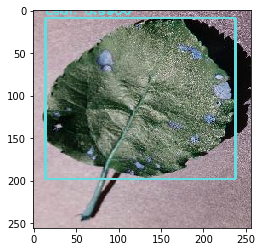

Cropped Image


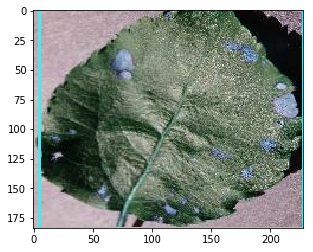

In [11]:
from matplotlib import pyplot as plt

# ensure at least one detection exists
if len(idxs) > 0:
	# loop over the indexes we are keeping
	for i in idxs.flatten():
		# extract the bounding box coordinates
		(x, y) = (boxes[i][0], boxes[i][1])
		(w, h) = (boxes[i][2], boxes[i][3])
 
		# draw a bounding box rectangle and label on the image
		color = [int(c) for c in COLORS[classIDs[i]]]
		cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
		text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
		cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.5, color, 2)
 
# show the output cropped image
fin_x = x
fin_y = y
fin_xw = y+h
fin_yh = x+w
crop_img = image[fin_x:fin_xw,fin_y:fin_yh]

print("Bounding boxes ")
plt.imshow(image)
plt.show()

print("Cropped Image")
plt.imshow(crop_img)
plt.show()



##Main Classifier

Since we recieved the cropped-image we can pass it over the main classifier to classifiy the input into the 8 classes of plants from the dataset. 

Load the weights trained on ResNet-50 from the disk.

In [12]:
model = load_model('/content/drive/My Drive/Leaf Weights/Weights/LeafClassifier.h5')

W0801 01:03:59.634882 140353582946176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0801 01:03:59.709337 140353582946176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0801 01:03:59.710522 140353582946176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0801 01:03:59.711519 140353582946176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0801 01:03:59.712598 140353

Now in this block: 
* We rotate the cropped image around 360 degrees of 15 degrees at each step
* We rotate the image because, so that we can average different orientations regardless of how the image is taken.
* For each rotation of the image, we output the corresponding class label.

  * 0: 'Apple'
  * 1: 'Cherry'
  * 2: 'Grape'
  * 3: 'Peach'
  * 4: 'Pepper'
  * 5: 'Potato'
  * 6: 'Strawberry'
  * 7: 'Tomato'

In [13]:
predictions=[]
for i in range(8):
	predictions.append(0)
i=1
for angle in range(0,360,15):
    rotated = imutils.rotate_bound(crop_img,angle)
    # print(i)
    cv2.imwrite("rotations/rotated_"+str(i)+".jpg",rotated)
    kerasimg = kimage.load_img('rotations/rotated_'+str(i)+".jpg",target_size=(224,224))
    kerasimg = kimage.img_to_array(kerasimg)
    kerasimg = np.expand_dims(kerasimg,axis=0)
    # predictions.append([round(x) for x in model.predict(kerasimg).tolist()])
    # print(model.predict(kerasimg))
    # print([round(x) for x in model.predict(kerasimg)[0].tolist()])
    predvec = model.predict(kerasimg)[0].tolist()
    predindex = predvec.index(max(predvec))
    print(predindex)
    predictions[predindex] += 1
    i=i+1


0
0
0
4
0
4
0
0
0
0
0
4
0
0
0
0
0
4
0
4
0
4
0
0


In this block we 
* Declare the paths to the weights of sub classifier.
* Declare the disease list respect to each class.

In [14]:
import shutil
print(predictions)
category = {0:'Apple',1:'Cherry',2:'Grape',3:'Peach',4:'Pepper',5:'Potato',6:'Strawberry',7:'Tomato'}
print(category[predictions.index(max(predictions))])
index = predictions.index(max(predictions))
# leafclass = category[predictions.index(max(predictions))]

paths = {
0:'/content/drive/My Drive/Leaf Weights/Weights/appleweights.h5',
1:'/content/drive/My Drive/Leaf Weights/Weights/cherryweights.h5',
2:'/content/drive/My Drive/Leaf Weights/Weights/grapeweights.h5',
3:'/content/drive/My Drive/Leaf Weights/Weights/peachweights.h5',
4:'/content/drive/My Drive/Leaf Weights/Weights/pepperweights.h5',
5:'/content/drive/My Drive/Leaf Weights/Weights/potatoweights.h5',
6:'/content/drive/My Drive/Leaf Weights/Weights/strawberryweights.h5',
7:'/content/drive/My Drive/Leaf Weights/Weights/tomatoweights.h5'}

diseaselist = [['Apple Scab','Black Rot', 'Cedar Apple Rust','Healthy'],
['Healthy','Powdery Mildew'],
['Black Measles','Black Rot','Healthy','Isariopsis Leaf Spot'],
['Bacterial Spot','Healthy'],
['Bacterial Spot','Healthy'],
['Early Blight','Healthy','Late Blight'],
['Healthy','Leaf Scorch'],
['Bacterial Spot','Curl Virus','Early Blight','Healthy','Late Blight','Leaf Mold','Mosaic Virus','Septoria Leaf Spot','Spider Mites','Target Spot']]


[18, 0, 0, 0, 6, 0, 0, 0]
Apple


##Sub Classifiers

Following blocks includes loading of the weights og the sub classifiers.

In [0]:
def load_cherry():
	model = Sequential()
	model.add(ResNet50(include_top = False, pooling = 'avg'))
	model.add(Dense(2, activation = 'softmax'))
	model.layers[0].trainable = False
	model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
	model.summary()
	model.load_weights(paths[1])

In [0]:
def load_pepper():
	model = ResNet50(include_top=False,pooling='avg',weights="imagenet")
	x = model.output
	# x = Dense(1024,activation='relu')(x)
	x = Dropout(0.12)(x)
	predict = Dense(2,activation='softmax')(x)
	model = Model(input = model.input, output = predict)
	model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
	model.summary()
	model.load_weights(paths[4])


In [0]:
def load_strawberry():
	model = Sequential()
	model.add(ResNet50(include_top = False, pooling = 'avg'))
	model.add(Dense(2, activation = 'softmax'))
	model.layers[0].trainable = False
	model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
	model.summary()
	model.load_weights(paths[6])


In [0]:
def load_tomato():
	model = ResNet50(include_top=False,pooling='avg',weights="imagenet")
	x = model.output
	x = Dropout(0.12)(x)
	predict = Dense(10,activation='softmax')(x)
	model = Model(input = model.input, output = predict)  
	model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
	model.load_weights(paths[7])


Lad the image and predict the disease names

In [23]:
kerasimg = kimage.load_img('/content/yolo_dataset/Apple/test/apple_black_rot/apple_BR1.jpg',target_size=(224,224))
# kerasimg = kimage.load_img('/home/varavindhan/obj/AppleClassify/test_set/Black Rot/rot_524.jpg',target_size=(224,224))
kerasimg = kimage.img_to_array(kerasimg)
kerasimg = np.expand_dims(kerasimg,axis=0)

if index in [0,2,3,5]:
	model = load_model(paths[index])
else:
	if index == 1:
		load_cherry()
	elif index == 4:
		load_pepper()
	elif index == 6:
		load_strawberry()
	else:
		load_tomato()
    
temp = model.predict(kerasimg)
temp = temp[0].tolist()
print("The disease : "+category[predictions.index(max(predictions))]+diseaselist[index][temp.index(max(temp))])
print()    

The disease : AppleBlack Rot

